In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_csv("/content/drive/MyDrive/AI work/AB_NYC_2019.csv")

print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (48895, 16)
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149            

In [3]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review      

In [4]:
# Drop irrelevant text columns (not useful for regression)
df_clean = df.drop(columns=["id", "name", "host_name", "last_review"])

# Fill missing values in reviews_per_month
df_clean["reviews_per_month"] = df_clean["reviews_per_month"].fillna(0)

# Drop remaining missing rows
df_clean = df_clean.dropna()

print("Clean Dataset Shape:", df_clean.shape)


Clean Dataset Shape: (48895, 12)


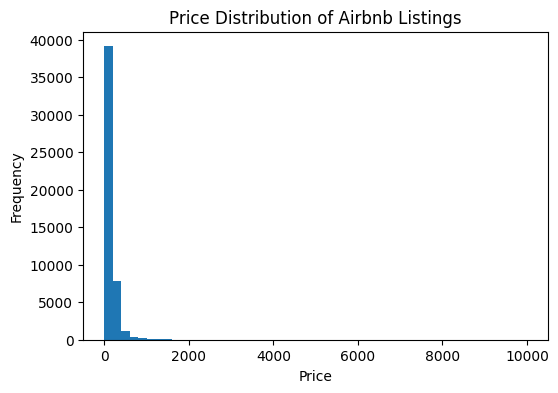

In [5]:
plt.figure(figsize=(6,4))
plt.hist(df_clean["price"], bins=50)
plt.title("Price Distribution of Airbnb Listings")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


In [6]:
df_encoded = df_clean.copy()

label_encoders = {}
for col in ["neighbourhood_group", "neighbourhood", "room_type"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le


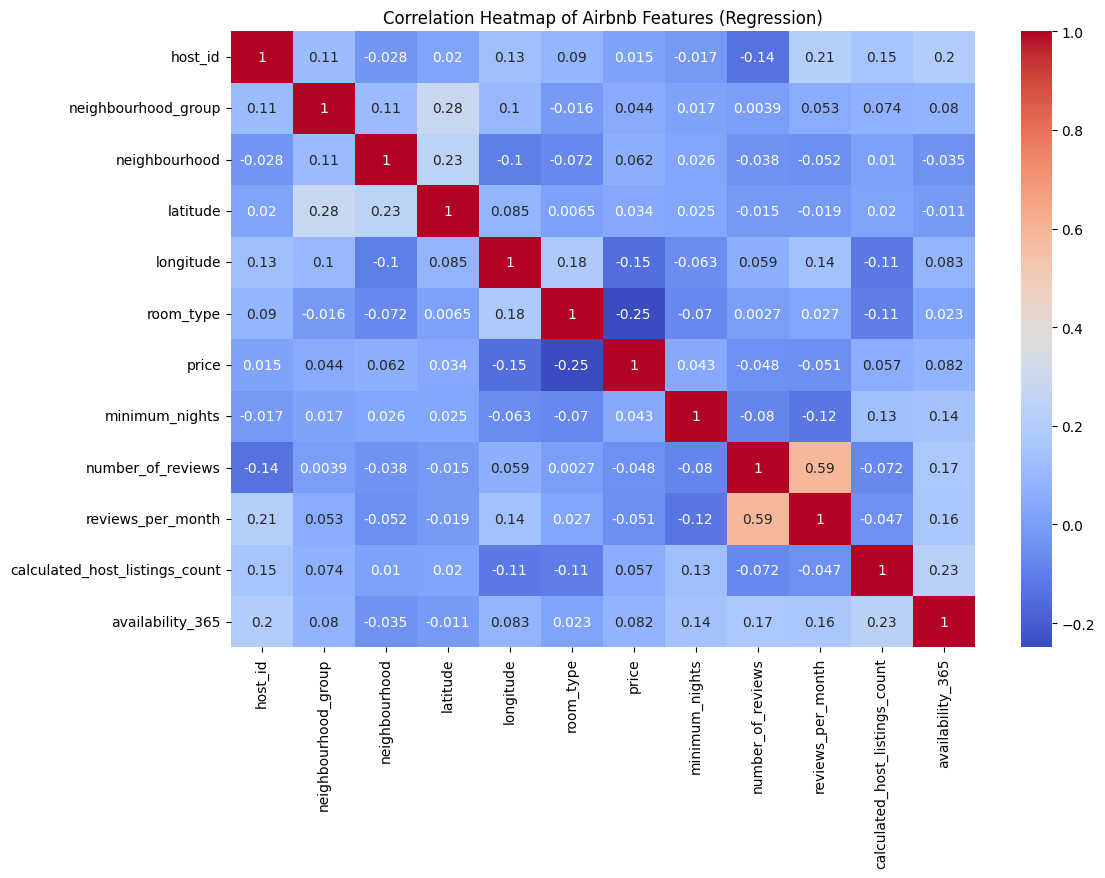

In [7]:
corr_matrix = df_encoded.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Airbnb Features (Regression)")
plt.show()


In [8]:
# Features = all columns except price
X = df_encoded.drop("price", axis=1)

# Target = price
y = df_encoded["price"]

print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)


Feature Shape: (48895, 11)
Target Shape: (48895,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


Training Samples: 39116
Testing Samples: 9779


In [10]:
def evaluate_regression(model, X_test, y_test):
    """
    Evaluates regression model using:
    RMSE, MAE, and R² Score
    """
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return rmse, mae, r2


In [11]:
lin_model = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

lin_model.fit(X_train, y_train)

rmse_lin, mae_lin, r2_lin = evaluate_regression(lin_model, X_test, y_test)

print("\nLinear Regression Results:")
print("RMSE:", rmse_lin)
print("MAE :", mae_lin)
print("R²  :", r2_lin)



Linear Regression Results:
RMSE: 198.40271162828907
MAE : 71.97981544193149
R²  : 0.11018978517411138


In [12]:
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)

tree_model.fit(X_train, y_train)

rmse_tree, mae_tree, r2_tree = evaluate_regression(tree_model, X_test, y_test)

print("\nDecision Tree Regression Results:")
print("RMSE:", rmse_tree)
print("MAE :", mae_tree)
print("R²  :", r2_tree)



Decision Tree Regression Results:
RMSE: 314.34115129624723
MAE : 70.21135489910012
R²  : -1.233596184168443


In [13]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

rmse_rf, mae_rf, r2_rf = evaluate_regression(rf_model, X_test, y_test)

print("\nRandom Forest Regression Results:")
print("RMSE:", rmse_rf)
print("MAE :", mae_rf)
print("R²  :", r2_rf)



Random Forest Regression Results:
RMSE: 194.6882941858397
MAE : 62.61368595970958
R²  : 0.14319526091923906


In [14]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "RMSE": [rmse_lin, rmse_tree, rmse_rf],
    "MAE": [mae_lin, mae_tree, mae_rf],
    "R2 Score": [r2_lin, r2_tree, r2_rf]
})

print("\nFinal Regression Model Comparison:")
print(results)



Final Regression Model Comparison:
               Model        RMSE        MAE  R2 Score
0  Linear Regression  198.402712  71.979815  0.110190
1      Decision Tree  314.341151  70.211355 -1.233596
2      Random Forest  194.688294  62.613686  0.143195


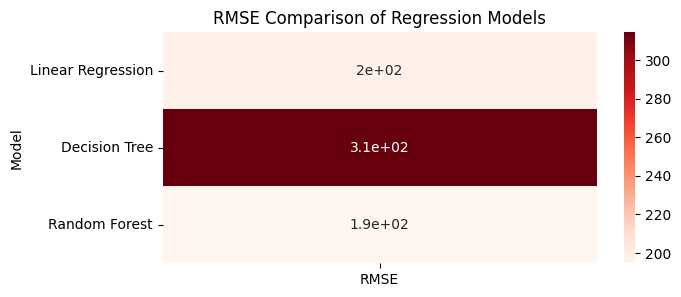

In [15]:
rmse_df = results[["Model", "RMSE"]].set_index("Model")

plt.figure(figsize=(7,3))
sns.heatmap(rmse_df, annot=True, cmap="Reds")
plt.title("RMSE Comparison of Regression Models")
plt.show()


In [16]:
best_model = results.loc[results["RMSE"].idxmin()]

print("\nBest Performing Regression Model (Lowest RMSE):")
print(best_model)



Best Performing Regression Model (Lowest RMSE):
Model       Random Forest
RMSE           194.688294
MAE             62.613686
R2 Score         0.143195
Name: 2, dtype: object
